In [79]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/unsupervised_learning` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [80]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "Lesson08"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Nonlinear manifold feature extraction

---

PCA is very useful when the data lies in a linear subspace, but what if the data forms a more complicated shape?

If a linear subspace is a flat sheet of paper, then a rolled up sheet of paper is a simple example of a **nonlinear manifold**.

Once rolled, a 2D plane occupies 3D space. Yet it is essentially still a 2D object. 
In other words, it has low intrinsic dimensionality. 

If we could somehow unroll the Swiss roll, we’d recover the 2D plane. This is the
goal of **nonlinear dimensionality reduction**, which assumes that the
manifold is simpler than the full dimension it occupies and attempts to unfold it.

In [81]:
import numpy as np

In [82]:
tt0 = 3 * np.pi / 2 * (1 + 2 * np.arange(0, 1.25, 0.01))
hh = np.arange(0, 1.125, 0.125) * 30
xx = np.transpose(np.tile(np.multiply(tt0, np.cos(tt0)), (len(hh), 1)))
yy = np.tile(hh, (len(tt0), 1))
zz = np.transpose(np.tile(np.multiply(tt0, np.sin(tt0)), (len(hh), 1)))
cc = np.transpose(np.tile((tt0-tt0.min())/(tt0.max()-tt0.min()), (len(hh), 1)))

In [83]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns
%matplotlib inline

In [84]:
sns.set_style('whitegrid')

In [85]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, 
                linewidth=0, antialiased=False, 
                facecolors=cm.seismic_r(cc))

The key observation is that even when a big manifold looks complicated,
the local neighborhood around each point can often be well approximated
with a patch of flat surface.

Clustering algorithms are usually not presented as techniques for local structure learning. But they in fact enable just that. 
Points that are close to each other (where “closeness” can be defined by a chosen metric) belong to the same cluster. 

Given a clustering, a data point can be represented by its cluster membership vector. If the number of clusters is smaller than the original number of features, then the new representation will have fewer dimensions than the original.
*The original data is compressed into a lower dimension*.

## k-Means Clustering

k-means is a clustering algorithm. Clustering algorithms group data depending on how they are laid out in space. They are **unsupervised** in that they do not require any sort of label—it’s the algorithm’s job to infer cluster labels based solely on the geometry of the data itself.



A clustering algorithm depends on a metric—a measurement of closeness between data points. The most popular metric is the *Euclidean distance*.

$$
|| x - y ||_2
$$

k-means establishes a hard clustering, meaning that each data point is assigned to one and only one cluster. The algorithm learns to position the cluster centers such that the total sum of the Euclidean distance between each data point and its cluster center is minimized.

$$
\mathrm{min}_{C_1,\dots,C_k,\mu_1,\dots,\mu_k} \sum_{i=1}^{k} \sum_{x \in C_i} || x - \mu_i ||_2
$$

Each cluster $C_i$ contains a subset of data points. The center of cluster $i$ is equal to the average of all the data points in the cluster.

$$ \mu_i = \sum_{x \in C_i} x/n_i  $$

In [86]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [87]:
import warnings
warnings.filterwarnings('ignore')

In [88]:
n_data = 1000
seed = 1
n_centers = 4

# Generate random Gaussian blobs and run K-means
blobs, blob_labels = make_blobs(n_samples=n_data, n_features=2, 
                                centers=n_centers, random_state=seed)
clusters_blob = KMeans(n_clusters=n_centers, random_state=seed).fit_predict(blobs)

# Generate data uniformly at random and run K-means
uniform = np.random.rand(n_data, 2)
clusters_uniform = KMeans(n_clusters=n_centers, random_state=seed).fit_predict(uniform)

In [89]:
figure = plt.figure(figsize=(20,10))
plt.subplot(221)
plt.scatter(blobs[:, 0], blobs[:, 1], c=blob_labels, edgecolors='k', cmap='PuRd')
plt.title("(a) Four randomly generated blobs", fontsize=14)
plt.axis('off')

plt.subplot(222)
plt.scatter(blobs[:, 0], blobs[:, 1], c=clusters_blob, edgecolors='k', cmap='PuRd')
plt.title("(b) Clusters found via K-means", fontsize=14)
plt.axis('off')

plt.subplot(223)
plt.scatter(uniform[:, 0], uniform[:, 1], edgecolors='k')
plt.title("(c) 1000 randomly generated pois", fontsize=14)
plt.axis('off')

plt.subplot(224)
plt.scatter(uniform[:, 0], uniform[:, 1], c=clusters_uniform, edgecolors='k', cmap='PuRd')
plt.title("(d) Clusters found via K-means", fontsize=14)
plt.axis('off')

(-0.04985986725449758,
 1.049797288107265,
 -0.04898087922422882,
 1.0489149400550117)

Common applications of clustering assume that there are natural clusters to be found; i.e., there are regions of dense data scattered in an otherwise empty space.  In these situations, there is a notion of the correct number of clusters, and people have invented clustering indices that measure the quality of data groupings in order to select for k.

However, when data is spread out fairly uniformly like previous figure, there is no longer a correct number of clusters.

In this case, the role of a clustering algorithm is **vector quantization**, i.e., partitioning the data into a finite number of chunks. The number of clusters can be selected based on acceptable approximation error when using quantized vectors instead of the original ones.

Uniform distribution is the worst-case scenario for k-means. If data density is not uniform, then we will be able to represent more data with fewer clusters. In general, it is difficult to tell how data is distributed in high-dimensional space. One can be conservative and pick a larger k, but it can’t be too large, because k will become the number of features for the next modeling step.

Visually, this usage of k-means can be thought of  as covering the data surface with patches, which is what we get if we run k-means on a *Swiss roll* dataset.

In [90]:
from sklearn import datasets

In [91]:
X, color = datasets.make_swiss_roll(n_samples=1500)

In [92]:
clusters_swiss_roll = KMeans(n_clusters=100, random_state=seed).fit_predict(X)

In [93]:
fig2 = plt.figure()
ax = fig2.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=clusters_swiss_roll, cmap='Spectral')

### The K-Means Algorithm

The K-Means algorithm is one of the fastest clustering algorithms, and also one of the simplest:
* First initialize $k$ centroids randomly: e.g., $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.

The `KMeans` class uses an optimized initialization technique by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"` and `n_init=1`. 

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

In [94]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)
        

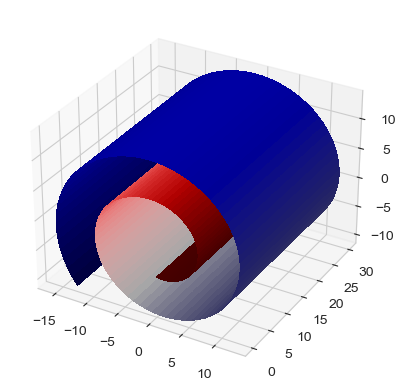

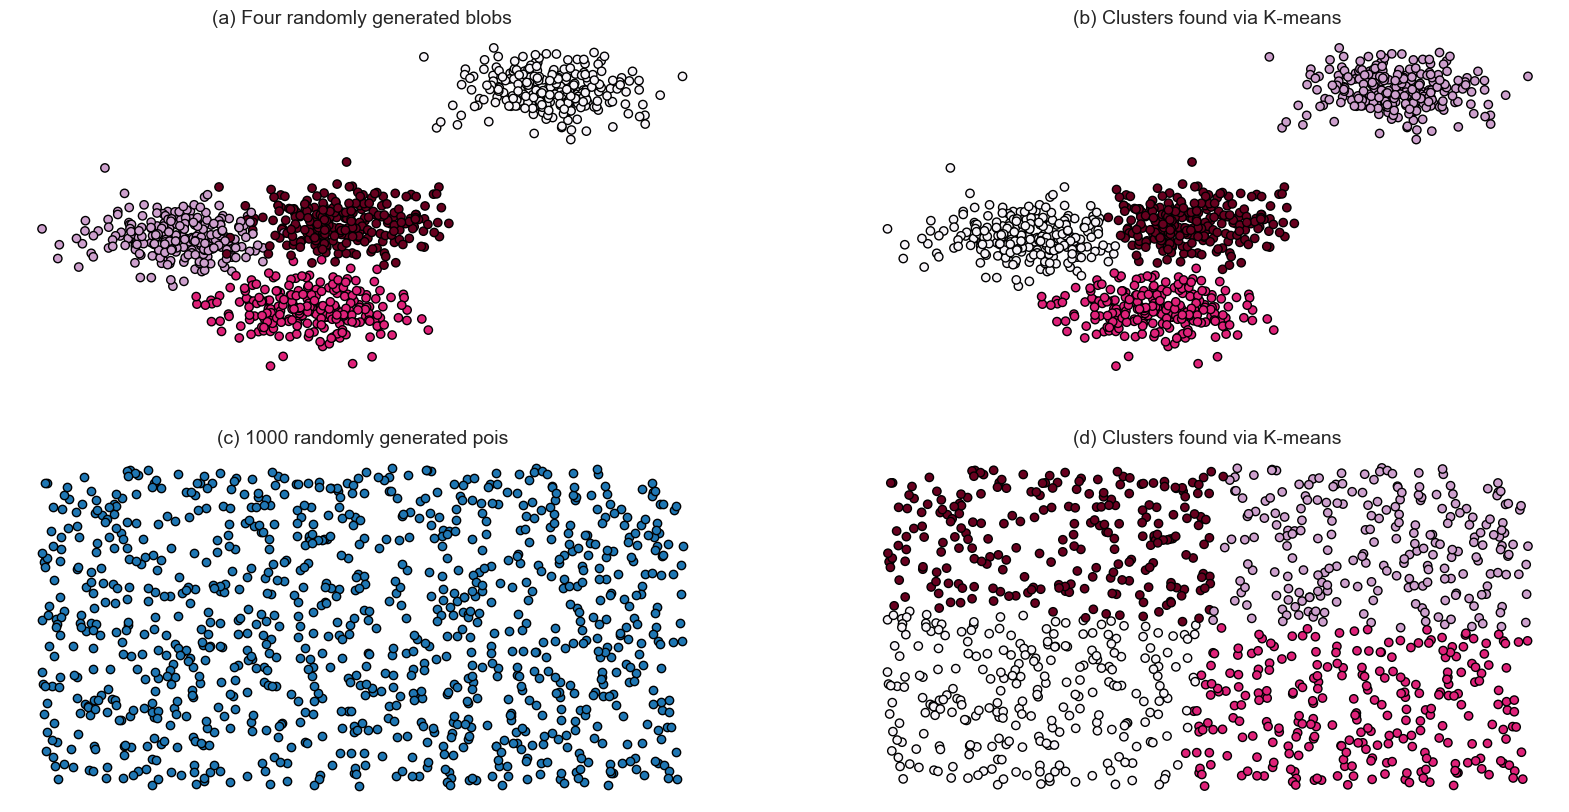

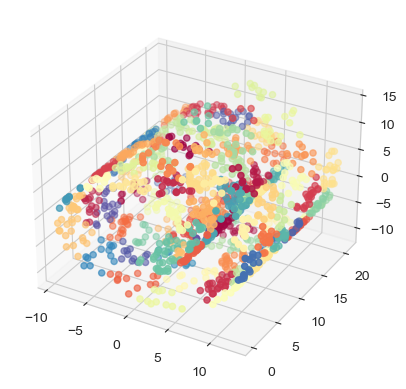

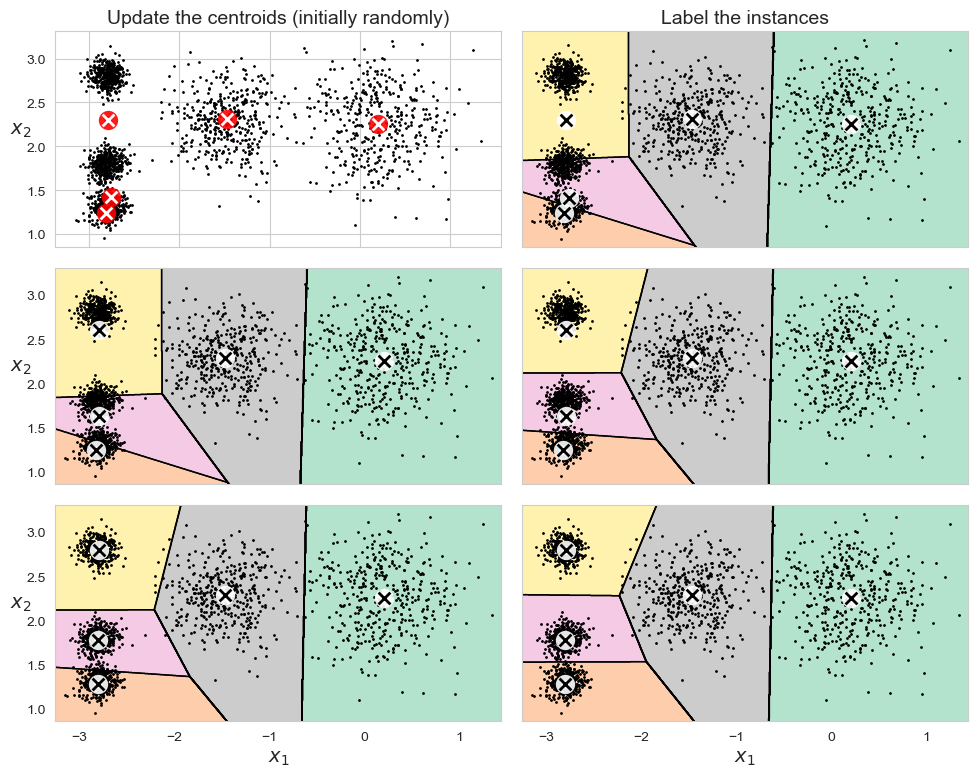

In [95]:
blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                  random_state=7)

kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=1,
                      random_state=1)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=2,
                      random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1, max_iter=3,
                      random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)")

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False,
                         show_ylabels=False)
plt.title("Label the instances")

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False,
                         show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False,
                         show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_plot")
plt.show()

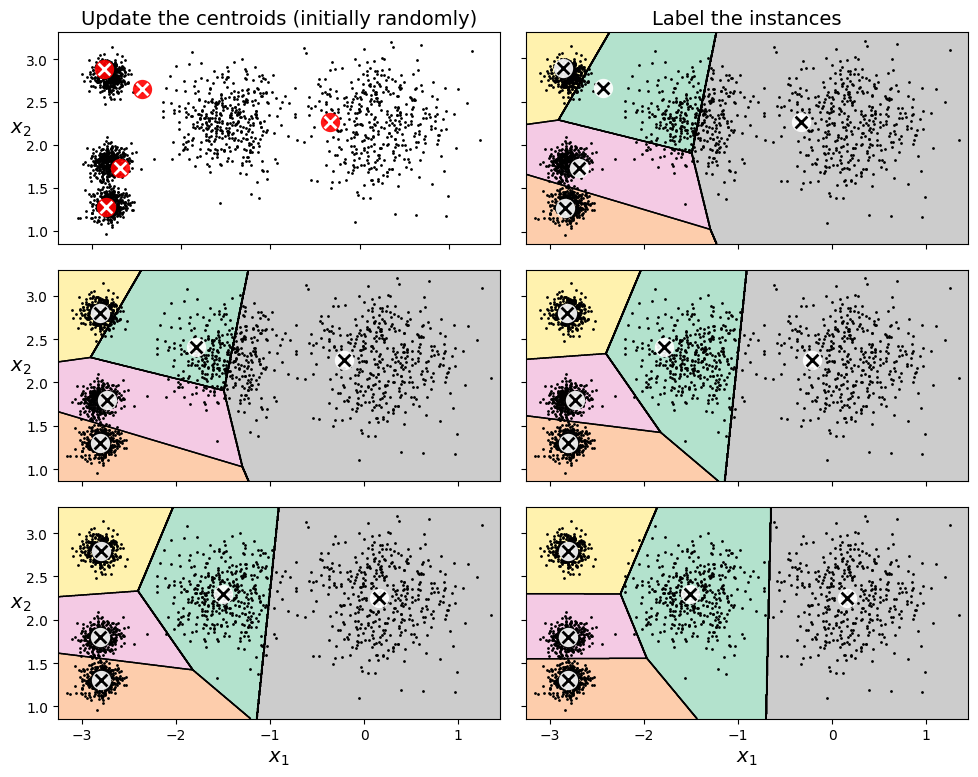

### Finding the Optimal Number of Clusters

A rather precise approach (but also more computationally expensive) is to use the **silhouette score**, 
which is the mean silhouette coefficient over all the instances. 

An instance’s *silhouette coefficient* is equal to $(b – a) / \mathrm{max}(a, b)$, where: 
- $a$ is the mean distance to the other instances in the same cluster (it is the mean intra-cluster distance), 
- $b$ is the mean nearest-cluster distance, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes b, excluding the instance’s own cluster). 

The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong
cluster. 

Let's plot the silhouette score as a function of $k$:

In [96]:

# the exact arguments of make_blobs() are not important
blob_centers = np.array([[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8],
                         [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                  random_state=7)

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

In [97]:
from sklearn.metrics import silhouette_score

In [98]:
silhouette_score(X, kmeans.labels_)

0.6267891051050734

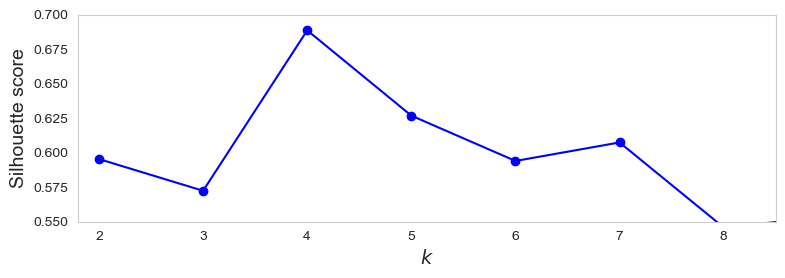

In [99]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.grid()
save_fig("silhouette_score_vs_k_plot")
plt.show()

As we can see, this visualization shows that $k=4$ is a very good choice, but it also underlines the fact that $k=5$ is quite good as well.

An even more informative visualization is given when plotting every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a _silhouette diagram_:

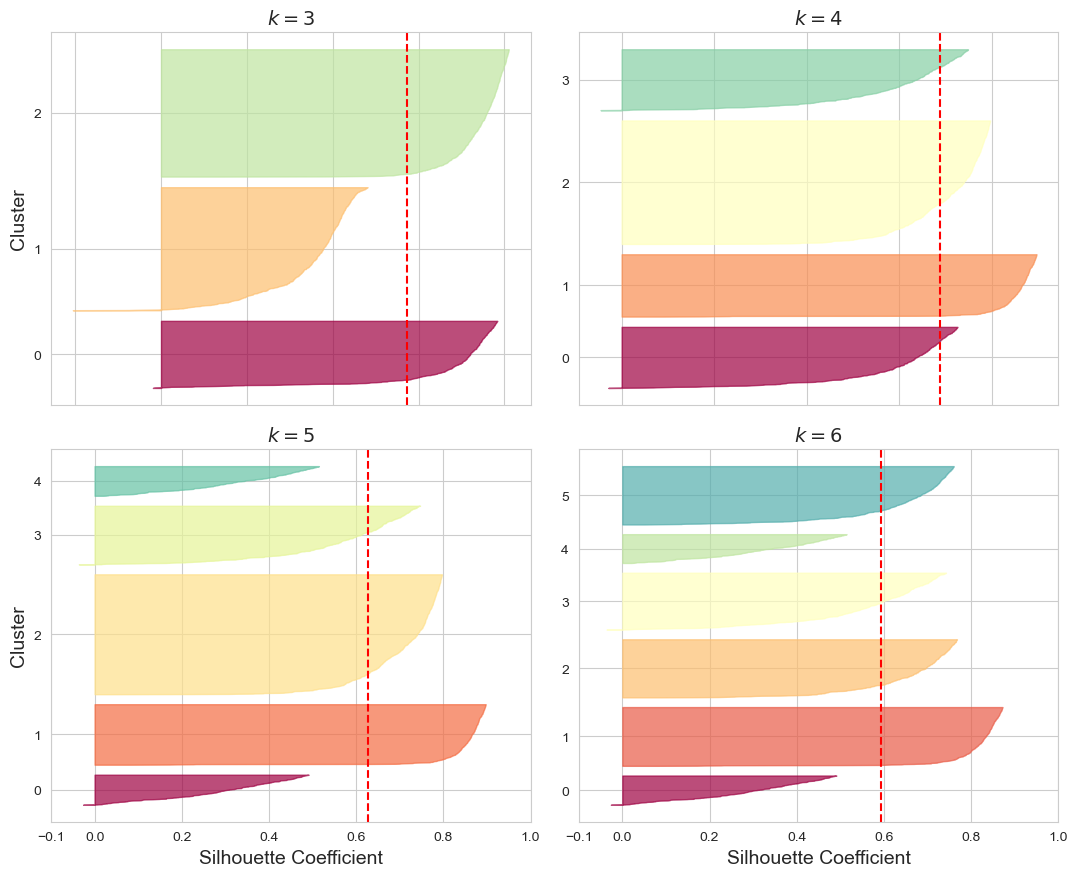

In [100]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

save_fig("silhouette_analysis_plot")
plt.show()

Here, $k=5$ looks like the best option, as all clusters are roughly the same size, and they all cross the dashed line, which represents the mean silhouette score.

## k-Means Featurization for Classification

Clustering algorithms analyze the spatial distribution of data. Therefore, k-means featurization creates a compressed spatial index of the data which can be fed into the model in the next stage.  This is an example of **model stacking**.

When using k-means as a featurization procedure, a data point can be represented by its cluster membership (a sparse one-hot encoding of the cluster membership categorical variable).

If a target variable is also available, then we have the choice of giving that information as a hint to the clustering procedure. One way to incorporate target information is to simply include the target variable as an additional input feature to the k-means algorithm. Since the objective is to minimize the total Euclidean distance over all input dimensions, the clustering procedure will attempt to balance similarity in the target value as well as in the original feature space. 

Larger differences in the target will produce clusters that pay more attention to the classification boundary, so the target values can be scaled to get more or less attention from the clustering algorithm. 

To illustrate the difference between using and not using target information when clustering, let's apply the featurizer to a synthetic dataset generated using `Scikit-Learn`’s `make_moons` function and plot the Voronoi diagram of the cluster boundaries.

In [101]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.datasets import make_moons
from sklearn.preprocessing import OneHotEncoder

In [102]:
class KMeansFeaturizer:
    """Transforms numeric data into k-means cluster memberships.
    
    This transformer runs k-means on the input data and converts each data point
    into the id of the closest cluster. If a target variable is present, it is 
    scaled and included as input to k-means in order to derive clusters that
    obey the classification boundary as well as group similar points together.

    Parameters
    ----------
    k: integer, optional, default 100
        The number of clusters to group data into.

    target_scale: float, [0, infty], optional, default 5.0
        The scaling factor for the target variable. Set this to zero to ignore
        the target. For classification problems, larger `target_scale` values 
        will produce clusters that better respect the class boundary.

    random_state : integer or numpy.RandomState, optional
        This is passed to k-means as the generator used to initialize the 
        kmeans centers. If an integer is given, it fixes the seed. Defaults to 
        the global numpy random number generator.

    Attributes
    ----------
    cluster_centers_ : array, [k, n_features]
        Coordinates of cluster centers. n_features does count the target column.
    """

    def __init__(self, k=100, target_scale=5.0, random_state=None):
        self.k = k
        self.target_scale = target_scale
        self.random_state = random_state
        self.cluster_encoder = OneHotEncoder().fit(np.array(range(k)).reshape(-1,1))
        
    def fit(self, X, y=None):
        """Runs k-means on the input data and find centroids.

        If no target is given (`y` is None) then run vanilla k-means on input
        `X`. 

        If target `y` is given, then include the target (weighted by 
        `target_scale`) as an extra dimension for k-means clustering. In this 
        case, run k-means twice, first with the target, then an extra iteration
        without.

        After fitting, the attribute `cluster_centers_` are set to the k-means
        centroids in the input space represented by `X`.

        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_data_points, n_features)

        y : vector of length n_data_points, optional, default None
            If provided, will be weighted with `target_scale` and included in 
            k-means clustering as hint.
        """
        if y is None:
            # No target variable, just do plain k-means
            km_model = KMeans(n_clusters=self.k, 
                              n_init=20, 
                              random_state=self.random_state)
            km_model.fit(X)

            self.km_model_ = km_model
            self.cluster_centers_ = km_model.cluster_centers_
            return self

        # There is target information. Apply appropriate scaling and include
        # into input data to k-means            
        data_with_target = np.hstack((X, y[:,np.newaxis]*self.target_scale))

        # Build a pre-training k-means model on data and target
        km_model_pretrain = KMeans(n_clusters=self.k, 
                                   n_init=20, 
                                   random_state=self.random_state)
        km_model_pretrain.fit(data_with_target)

        # Run k-means a second time to get the clusters in the original space
        # without target info. Initialize using centroids found in pre-training.
        # Go through a single iteration of cluster assignment and centroid 
        # recomputation.
        km_model = KMeans(n_clusters=self.k, 
                          init=km_model_pretrain.cluster_centers_[:,:2], 
                          n_init=1, 
                          max_iter=1)
        km_model.fit(X)
        
        self.km_model = km_model
        self.cluster_centers_ = km_model.cluster_centers_
        return self
        
    def transform(self, X, y=None):
        """Outputs the closest cluster id for each input data point.

        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_data_points, n_features)

        y : vector of length n_data_points, optional, default None
            Target vector is ignored even if provided.

        Returns
        -------
        cluster_ids : array, shape[n_data_points,1]
        """
        clusters = self.km_model.predict(X)
        return self.cluster_encoder.transform(clusters.reshape(-1,1))
    
    def fit_transform(self, X, y=None):
        """Runs fit followed by transform.
        """
        self.fit(X, y)
        return self.transform(X, y)

In [103]:
seed = 1
training_data, training_labels = make_moons(n_samples=2000, noise=0.2, random_state=seed)

In [104]:
kmf_hint = KMeansFeaturizer(k=100, target_scale=10, random_state=seed).fit(training_data, training_labels)
kmf_no_hint = KMeansFeaturizer(k=100, target_scale=0, random_state=seed).fit(training_data, training_labels)

In [105]:
def kmeans_voronoi_plot(X, y, cluster_centers, ax):
    """Plots the Voronoi diagram of the kmeans clusters overlayed with the data"""
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='Set1', alpha=0.2)
    vor = Voronoi(cluster_centers)
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, alpha=0.5)

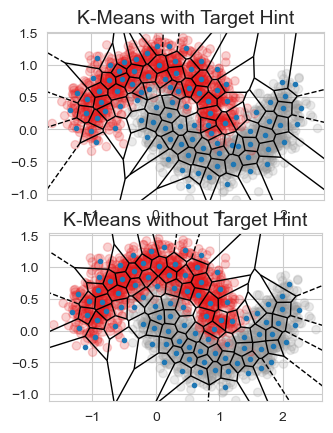

In [106]:
fig = plt.figure()
ax = plt.subplot(211, aspect='equal')
kmeans_voronoi_plot(training_data, training_labels, kmf_hint.cluster_centers_, ax)
ax.set_title('K-Means with Target Hint')
ax2 = plt.subplot(212, aspect='equal')
kmeans_voronoi_plot(training_data, training_labels, kmf_no_hint.cluster_centers_, ax2)
ax2.set_title('K-Means without Target Hint')
plt.show()

The bottom panel shows the clusters trained without target information. Notice that a number of clusters span the empty space between the two classes. The top panel shows that when the clustering algorithm is given target information, the cluster boundaries align much better along class boundaries.

### Classification with KMeans clustering features

In [107]:
import sklearn
import scipy

In [108]:
test_data, test_labels = make_moons(n_samples=2000, noise=0.3, random_state=seed+5)

In [109]:
training_cluster_features = kmf_hint.transform(training_data)
test_cluster_features = kmf_hint.transform(test_data)

training_with_cluster = scipy.sparse.hstack((training_data, training_cluster_features))
test_with_cluster = scipy.sparse.hstack((test_data, test_cluster_features))

In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [111]:
lr_cluster = LogisticRegression(random_state=seed).fit(training_with_cluster, training_labels)

classifier_names = ['LR',
                    'Random Forest']
classifiers = [LogisticRegression(random_state=seed),
               RandomForestClassifier(max_depth=5, n_estimators=10, 
                                      max_features=1, random_state=seed)]
for model in classifiers:
    model.fit(training_data, training_labels)

In [112]:
def test_roc(model, data, labels):
    if hasattr(model, "decision_function"):
        predictions = model.decision_function(data)
    else:
        predictions = model.predict_proba(data)[:,1]
    fpr, tpr, _ = sklearn.metrics.roc_curve(labels, predictions)
    return fpr, tpr

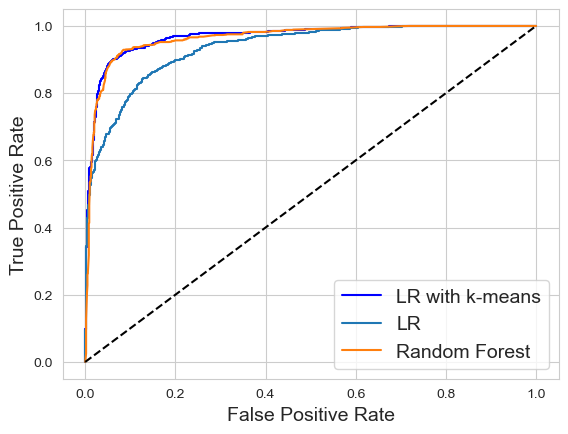

In [113]:
plt.figure()
fpr_cluster, tpr_cluster = test_roc(lr_cluster, test_with_cluster, test_labels)
plt.plot(fpr_cluster, tpr_cluster, 'b-', label='LR with k-means')

for i, model in enumerate(classifiers):
    fpr, tpr = test_roc(model, test_data, test_labels)
    plt.plot(fpr, tpr, label=classifier_names[i])
    
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.show()

Our plot shows that logistic regression performs much better with cluster features than without. In fact, with cluster features, the linear classifier performs just as well as nonlinear classifiers.

One minor caveat is that in this toy example, we did not tune the hyperparameters for any of the models. 

However, this is a interesting result because linear classifiers are much cheaper to train than nonlinear classifiers. Lower computation cost allows us to try more models with different features in the same period of time, which increases the chance of ending up with a much better model.

k-Means + LR is the only combination that is linear (with respect to the size of training data, $O(nd)$, and model size, $O(kd)$) at both training and prediction time.

## Using Clustering for Unsupervised Learning

Although most of the applications of Machine Learning today are based on supervised learning, the vast majority of the available data is actually unlabeled: we have the input features $X$, but we do not have the labels $y$.

>**Unsupervised learning** exploits the unlabeled data without needing humans to label every data point.

### A Case Study: Image Segmentation

**Image segmentation** is the task of partitioning an image into multiple segments. 

In **semantic segmentation**, all pixels that are part of the same object type get assigned to the same segment.

In **instance segmentation**, all pixels that are part of the same individual object are assigned to the same segment.

Here, we are going to do something much simpler: **color segmentation**. We will simply assign pixels to the same segment if they have a similar color.

In [114]:
# Fetch the MedMNIST dataset
import medmnist
import os

# Choose a specific MedMNIST dataset (e.g., 'pathmnist')
data_flag = 'bloodmnist'
download = False

# Ensure the target folder exists
os.makedirs('./datasets/ch4', exist_ok=True)

# Load the chosen MedMNIST dataset
info = medmnist.INFO[data_flag]
dataset_class = getattr(medmnist, info['python_class'])
train_dataset = dataset_class(split='train', download=download, root='./datasets/ch4')
image = train_dataset.imgs[0]

The image is represented as a 3D array: the first dimension’s size is the height, the second is the width, and the third is the number of color channels, in this case red, green and blue (RGB).

In [115]:
image.shape

(28, 28, 3)

The following code does the following:
1. Reshapes the array to get a long list of RGB colors, 
2. Then it clusters these colors using K-Means. 
3. Next, for each color (e.g., purple), it looks for the mean color of the pixel’s color cluster. 
4. Finally it reshapes this long list of colors to get the same shape as the original image.

In [116]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

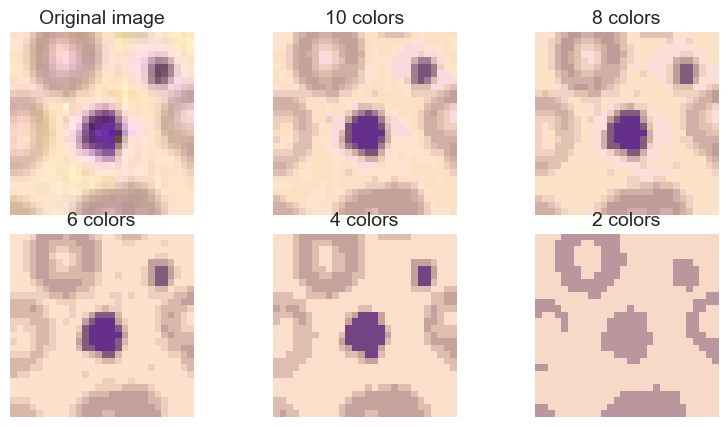

In [117]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(2, 3, 2 + idx)
    plt.imshow(segmented_imgs[idx] / 255)
    plt.title(f"{n_clusters} colors")
    plt.axis('off')

plt.show()

When you use less than 4 clusters, the granulocyte's purple color fails to get a cluster of its own.
This is due to the fact that the granulocyte is a little bit smaller than the rest of the image, so even though its color is flashy, K-Means fails to dedicate a cluster to it: 
>K-Means prefers clusters of similar sizes.